In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
#tiding
pumpkin_data<-read_csv("Pumpkin_Seeds_Dataset.csv")
pumpkin_data[pumpkin_data=="Çerçevelik"]<-"Cercevelik"
pumpkin_data[pumpkin_data=="Ürgüp Sivrisi"]<-"Urgup Sivrisi"
pumpkin_data<-pumpkin_data%>%mutate(Class=as_factor(Class))
pumpkin_data

Parsed with column specification:
cols(
  Area = col_double(),
  Perimeter = col_double(),
  Major_Axis_Length = col_double(),
  Minor_Axis_Length = col_double(),
  Convex_Area = col_double(),
  Equiv_Diameter = col_double(),
  Eccentricity = col_double(),
  Solidity = col_double(),
  Extent = col_double(),
  Roundness = col_double(),
  Aspect_Ration = col_double(),
  Compactness = col_double(),
  Class = col_character()
)



Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,Cercevelik
76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,Cercevelik
71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,Cercevelik
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
87994,1210.314,507.2200,222.1872,88702,334.7199,0.8990,0.9920,0.7643,0.7549,2.2828,0.6599,Urgup Sivrisi
80011,1182.947,501.9065,204.7531,80902,319.1758,0.9130,0.9890,0.7374,0.7185,2.4513,0.6359,Urgup Sivrisi
84934,1159.933,462.8951,234.5597,85781,328.8485,0.8621,0.9901,0.7360,0.7933,1.9735,0.7104,Urgup Sivrisi


In [3]:
pumpkin_split<-initial_split(pumpkin_data, prop = 0.75, strata = Class)
pumpkin_train <- training(pumpkin_split)
pumpkin_test <- testing(pumpkin_split)


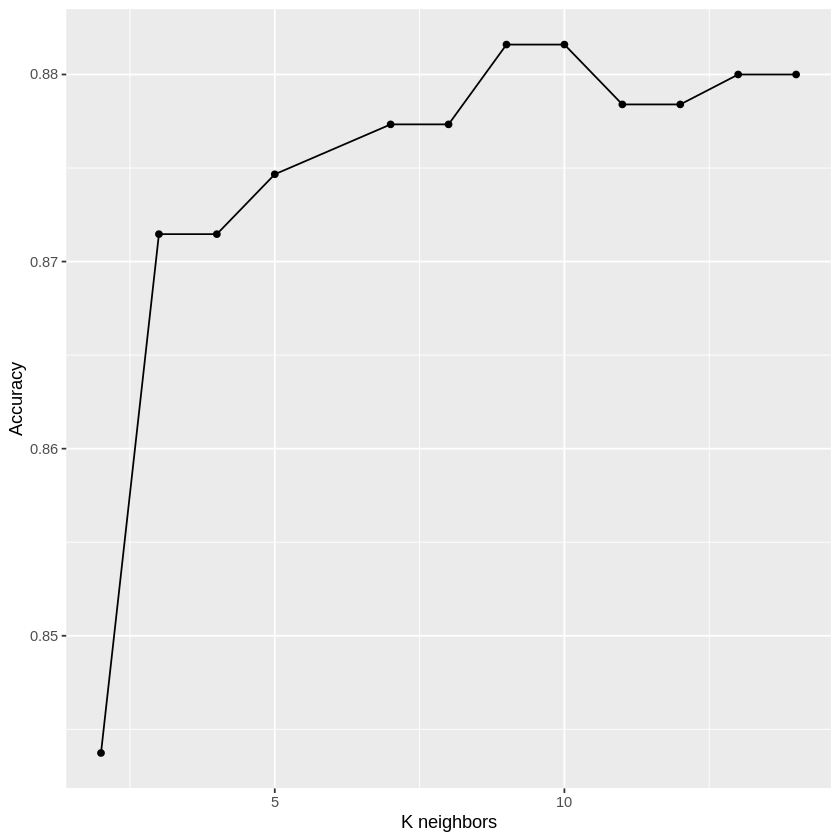

In [6]:
set.seed(2020) # DO NOT REMOVE


#Error: if I uncomment centering in the line below it gives me an error, so that I cannnot gind best number of neighbors we should use
#Not all functions are allowed in step function selectors (e.g. `all_pedictors`). See ?selections  - the error
#Try doing it and you'll see
#I am not sure why

pumpkin_recipe<-recipe(Class~., data = pumpkin_train)%>%step_scale(all_predictors())#%>%step_center(all_pedictors())

pumpkin_model<-nearest_neighbor(weight_func="rectangular", neighbors = tune())%>% set_engine("kknn") %>%set_mode("classification")

pumpkin_vfold<-vfold_cv(pumpkin_train, v = 5, strata = Class)

pumpkin_workflow<-workflow()%>%add_recipe(pumpkin_recipe)%>%add_model(pumpkin_model)

pumpkin_metrics<-pumpkin_workflow%>%tune_grid(resamples = pumpkin_vfold, grid = 15)%>%collect_metrics()


accuracies<-pumpkin_metrics%>%filter(.metric=="accuracy")


best_k<-accuracies%>% arrange(desc(mean))%>%select(neighbors)%>%slice(1)%>%pull()

cross_val_plot<-accuracies%>% ggplot(aes(x = neighbors, y = mean)) + geom_point() + geom_line() +labs(x = "K neighbors", y = "Accuracy")
cross_val_plot



In [7]:
best_model<-nearest_neighbor(weight_func="rectangular", neighbors = best_k)%>% set_engine("kknn") %>%set_mode("classification")

best_fit<-workflow()%>%add_recipe(pumpkin_recipe)%>%add_model(best_model)%>%fit(pumpkin_train)

predictions<-best_fit%>%predict(pumpkin_test)%>%bind_cols(pumpkin_test)

metrics<-predictions%>%metrics(truth = Class, estimate = .pred_class)%>%filter(.metric=="accuracy")
metrics
conf_mat<-predictions%>%conf_mat(truth = Class, estimate = .pred_class)
conf_mat

.pred_class,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Cercevelik,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,Cercevelik
Cercevelik,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,Cercevelik
Cercevelik,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,Cercevelik
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Urgup Sivrisi,92886,1211.852,501.5779,237.1213,93503,343.8984,0.8812,0.9934,0.6180,0.7948,2.1153,0.6856,Urgup Sivrisi
Urgup Sivrisi,51555,934.911,401.8321,164.7038,52013,256.2067,0.9121,0.9912,0.7187,0.7412,2.4397,0.6376,Urgup Sivrisi
Urgup Sivrisi,69647,1084.318,462.9416,191.8210,70216,297.7874,0.9101,0.9919,0.6002,0.7444,2.4134,0.6433,Urgup Sivrisi


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8768


               Truth
Prediction      Cercevelik Urgup Sivrisi
  Cercevelik           295            47
  Urgup Sivrisi         30           253